# Lab 2 - Exploring Text Data

### Eric Smith and Jake Carlson

## Introduction
For this lab we will be examining questions and answers on the popular programming Q&A website, Stack Overflow. Stack Overflow allows programmers who are stuck on a problem ask the community about ways to resolve or circumvent said problem. This helps people write more accurate code faster. However, the community can be pretty hard on those who do not fully understand their question or are disrespectful. It could also be the case that the few developers who have experience with a problem similar to yours are not on the website when you post your question. If too much time passes, your post may be burried forever. This makes for some interesing questions. When should you make your post so that it has the highest chance of being answered? Are there specific keywords or phasing that encourage other programmers to answer your questions? Are there specific languages that have their questions answered faster than others? These are questions we will be exploring int his lab.

## Business Understanding

### Motivations
Stack Overflow is a go-to resource for developers. Questions are often distilled down to a single block of code that is easily digestible, and can be matched to the question you came to the site for. However, if you're truly stuck on something, it can seem like an eternity of waiting before someone responds to your question, and sometimes, it may not be answered at all. If you're working in industry and spending a lot of time waiting for a question to be answered, you could fall behind schedule and miss deadlines. These delays could cost your company a great deal in lost revenue and tech debt. Therefore, accurately predicting the amount of time to get a question answered can be seen as a valuable project management tool.

### Objectives
It would be useful if you could predict how quickly your question will be answered if you post it at various times through out the day. For a prediction tool like this to be useful, we want something that is 80-95% accurate in predicting when a question will be answered by. As a project manager, you want your developers to be asking questions that are concise and respectful. Therefore, a tool that could recommend keywords to add to your post to make it more attractive, and provide you with approximate gains in time for reformatting, would also be a valuable project management tool.

## Data Understanding

### Data Attributes
The following is a list of attributes in the data, their data types, and a brief description of the attribute.

#### Questions
- **Id** (nominal): A unique identifier for each question
- **OwnerUserId** (nominal): A unique identifier for the person who posted the question
- **CreationDate** (ordinal): A timestamp of when the question was posted
- **ClosedDare** (ordinal): A timestamp of when the question was closed, if the question wasn't closed this field is NaN
- **Score** (ordinal): ratio?? The number of upvotes a post has
- **Title** (text): A title for the question
- **Body** (text): The question body

#### Answers
- **Id** (nominal): A unique identifier for each answer
- **OwnerUserId** (nominal): A unique identifier for the person who posted the answer
- **CreationDate** (ordinal): A timestamp of when the answer was posted
- **ParentId** (nominal): The unique identifier of the question this answer is for
- **Score** (ordinal): ratio?? The number of upvotes an answer has
- **Body** (text): The answer body


## Data Quality
Our data it too big, so we will take a rendom subsample of 40% of the original data set.

In [56]:
import numpy as np
import pandas as pd

In [57]:
# read data
df = pd.read_csv('./data/Questions.csv', encoding='ISO-8859-1')

In [58]:
df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


Trial and error has shown us that 1,264,000 elements is too many to work with. Therefore, we will use a random sample to reduce our data set size to 12,000 elements.

In [60]:
df = df.sample(n=12000, replace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 524616 to 859010
Data columns (total 7 columns):
Id              12000 non-null int64
OwnerUserId     11881 non-null float64
CreationDate    12000 non-null object
ClosedDate      530 non-null object
Score           12000 non-null int64
Title           12000 non-null object
Body            12000 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 750.0+ KB


The body of each question is formatted in HTML, so we will need to parse through each body and remove the HTML tags. We also need to replace HTML entities with their character representations. Finally, many questions have accompanying code blocks, so we will parse out the code blocks into a new attribute for each entry.

In [61]:
from bs4 import BeautifulSoup
import html
import re

# compile regexes
tag_re = re.compile('<[^<]+?>')
newline_re = re.compile('\n+')

def clean_html(body_text):
    soup = BeautifulSoup(body_text, 'html.parser')
    code_tags = soup.findAll('code')
    code_text = ""
    
    # unescape html entities
    body_text = html.unescape(body_text)
    
    # remove code blocks, saving blocks to new string
    for c in code_tags:
        body_text = body_text.replace("<code>{}</code>".format(c.string),
                                      '')
        if c.string:
            code_text += c.string

    # remove remaining tags and multiple newlines
    body_text = tag_re.sub('', body_text)
    body_text = newline_re.sub('\n', body_text)
    
    return body_text, code_text

as_list = df.Body.tolist()
body_list = []
code_list = []
for i in range(len(as_list)):
    body_text, code_text = clean_html(as_list[i])
    body_list.append(body_text)
    code_list.append(code_text)

# update body column
df = df.assign(Body=body_list)
# add code column
df = df.assign(Code=code_list)
df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Code
524616,18215830,2336599.0,2013-08-13T17:46:39Z,NaN,0,Using Scanner to read an object from a file,Am trying to read an object from a text file u...,//writing object to the file using printwrite...
454060,15919240,1578199.0,2013-04-10T07:10:31Z,NaN,0,how to set Calendar with variable,I have a set calendar to set week of month in ...,Long date1 = cursor.getLong(12); // first I lo...
1128647,36600610,1772640.0,2016-04-13T13:54:00Z,NaN,3,Exception Handling within Exception Handling,What is the best practice for exception handli...,public void DoSomeStuff(string sGUID)\n ...
1164345,37554500,6406356.0,2016-05-31T19:52:46Z,NaN,0,file name is variable - does not write to file,I have a large file about some populations (co...,for item in d: # d is a set to hold the popula...
631142,21694580,3214052.0,2014-02-11T06:20:53Z,NaN,1,posting ASP.net MVC form having Kendoui widget...,I am developing my ASp.net MVC application usi...,public class Faculties\n{\n public int Facu...


With the HTML tags removed and the code isolated, the question body is much cleaner. Now lets add another column for the time in minutes it took to get the question answered. For this value, we will look for the highest rated answer for each question and use the time when that answer was posted.

In [62]:
df_ans = pd.read_csv('./data/Answers.csv', encoding='ISO-8859-1')
df_ans.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [63]:
df_ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014516 entries, 0 to 2014515
Data columns (total 6 columns):
Id              int64
OwnerUserId     float64
CreationDate    object
ParentId        int64
Score           int64
Body            object
dtypes: float64(1), int64(3), object(2)
memory usage: 92.2+ MB


In [64]:
ids = df.Id.unique()
df_ans = df_ans[df_ans.ParentId.isin(ids)]
df_ans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19075 entries, 571 to 2014399
Data columns (total 6 columns):
Id              19075 non-null int64
OwnerUserId     18939 non-null float64
CreationDate    19075 non-null object
ParentId        19075 non-null int64
Score           19075 non-null int64
Body            19075 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 1.0+ MB


We will clean the answers data frame using the same function as the questions data frame.

In [65]:
as_list = df_ans.Body.tolist()
body_list = []
code_list = []
for i in range(len(as_list)):
    body_text, code_text = clean_html(as_list[i])
    body_list.append(body_text)
    code_list.append(code_text)

# update body column
df_ans = df_ans.assign(Body=body_list)
# add code column
df_ans = df_ans.assign(Code=code_list)
df_ans.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,Code
571,14313,615.0,2008-08-18T08:10:30Z,14300,23,Drop into a cmd instance (or indeed PowerShell...,powershell -?\n
874,22835,NaN,2008-08-22T16:47:52Z,22340,1,"In most firewall setups, the TCP connection wi...",
1820,39257,1196.0,2008-09-02T11:26:10Z,39240,0,First of all you need to define what article s...,-- Assuming @Title contains title of current a...
1821,39270,3221.0,2008-09-02T11:32:13Z,39240,0,I think the question is what 'similar' means t...,
1823,39316,383.0,2008-09-02T11:52:02Z,39240,1,"Something like this might work, a kind of rank...","Select\nTop 10\nArticleID,\nArticleTitle,\nArt..."


In [66]:
# adapted from https://stackoverflow.com/questions/2788871/date-difference-in-minutes-in-python
from datetime import datetime
import time

fmt = '%Y-%m-%dT%H:%M:%SZ'
def get_minutes_diff(timestamp1, timestamp2):
#     if np.isnan(x.ClosedDate):
#         return np.nan
    d1 = datetime.strptime(timestamp1, fmt)
    d2 = datetime.strptime(timestamp2, fmt)
    
    # convert to unix timestamp
    d1_ts = time.mktime(d1.timetuple())
    d2_ts = time.mktime(d2.timetuple())
    
    # convert to minutes
    return int(d2_ts - d1_ts) / 60

durations = []
for i, row in df.iterrows():
    answer = df_ans[ df_ans.ParentId == row.Id ]
    answer = answer[ answer.Score == answer.Score.max() ]
    answer_time = answer.CreationDate.values
    if len(answer_time) > 0:
        answer_time = answer_time[0]
        dur = get_minutes_diff(row.CreationDate, answer_time)
        if dur > -1: 
            df.loc[i, 'Duration'] = dur

df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Code,Duration
524616,18215830,2336599.0,2013-08-13T17:46:39Z,NaN,0,Using Scanner to read an object from a file,Am trying to read an object from a text file u...,//writing object to the file using printwrite...,16.850000
454060,15919240,1578199.0,2013-04-10T07:10:31Z,NaN,0,how to set Calendar with variable,I have a set calendar to set week of month in ...,Long date1 = cursor.getLong(12); // first I lo...,24.216667
1128647,36600610,1772640.0,2016-04-13T13:54:00Z,NaN,3,Exception Handling within Exception Handling,What is the best practice for exception handli...,public void DoSomeStuff(string sGUID)\n ...,3.733333
1164345,37554500,6406356.0,2016-05-31T19:52:46Z,NaN,0,file name is variable - does not write to file,I have a large file about some populations (co...,for item in d: # d is a set to hold the popula...,24.333333
631142,21694580,3214052.0,2014-02-11T06:20:53Z,NaN,1,posting ASP.net MVC form having Kendoui widget...,I am developing my ASp.net MVC application usi...,public class Faculties\n{\n public int Facu...,38974.066667


Load the tags and save the tags that correspond to a question.

In [67]:
df_tags = pd.read_csv('./data/Tags.csv', encoding='ISO-8859-1')
df_tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [68]:
ids = df.Id.unique()
df_tags = df_tags[df_tags.Id.isin(ids)]
df_tags.head()

,Id,Tag
403,14300,powershell
404,14300,batch-file
608,22340,.net
609,22340,wcf
610,22340,firewall


In [69]:
# http://www.labautopedia.org/mw/List_of_programming_and_computer_science_terms
topics = pd.read_csv('./data/CS_terms.csv', encoding='ISO-8859-1')
list_topics = [x.upper() for x in topics.Term.tolist()]

Save the cleaned data to a persistance file.

## Data Visualization

In [70]:
df.to_csv('./clean-data/Questions.csv', sep=',')
df_ans.to_csv('./clean-data/Answers.csv', sep=',')
df_tags.to_csv('./clean-data/Tags.csv', sep=',')

In [89]:
# tf-idf for most common words that appear in the body

import re
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(encoding='ISO-8859-1') 

tfidf_mat = tfidf_vect.fit_transform( df.Body.tolist() )

tfidf_mat = pd.DataFrame(data=tfidf_mat.toarray(),columns=tfidf_vect.get_feature_names())

common_words = tfidf_mat[ [col for col in tfidf_mat.columns if col.upper() in list_topics] ]
most_common_words = common_words.max().sort_values()[-10:]

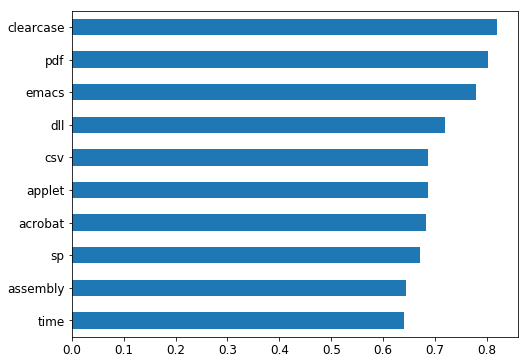

In [90]:
most_common_words.plot(kind='barh', fontsize=12, figsize=(8,6))
plt.show()

In [72]:
df = pd.read_csv('./clean-data/Questions.csv')
df_ans = pd.read_csv('./clean-data/Answers.csv')
df_tags = pd.read_csv('./clean-data/Tags.csv')

In [73]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35360 entries, 0 to 35359
Data columns (total 3 columns):
Unnamed: 0    35360 non-null int64
Id            35360 non-null int64
Tag           35358 non-null object
dtypes: int64(2), object(1)
memory usage: 828.8+ KB


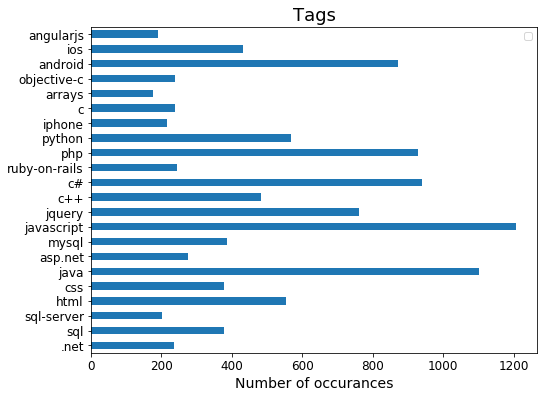

In [74]:
import matplotlib.pyplot as plt
from collections import Counter

tag_counts = Counter(df_tags.Tag)

# remove tags that have less than 175 occurances
for t in list(tag_counts):
    if tag_counts[t] < 175:
        del tag_counts[t]

df_tag_counts = pd.DataFrame.from_dict(tag_counts, orient='index')
df_tag_counts.plot(kind='barh', fontsize=12, figsize=(8,6))
plt.xlabel('Number of occurances', fontsize=14)
plt.title('Tags', fontsize=18)
plt.legend([])
plt.show()

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
bag_words = count_vect.fit_transform(df.Title.tolist())

In [76]:
len(count_vect.vocabulary_)

10216

In [77]:
df_title = pd.DataFrame(data=bag_words.toarray(), 
                        columns=count_vect.get_feature_names())

In [78]:
# print 10 most common words
df_title.sum().sort_values()[-10:]

value      325
use        328
php        350
jquery     353
java       368
error      440
data       441
android    442
file       546
using      889
dtype: int64

In [79]:
# adapted from https://stackoverflow.com/a/16359854
# 1 day = 86400 seconds
# 1 week = 604800 seconds
import sys

# put the durations into different buckets, graph the result
# only count the durations that are not null
df_durations = pd.cut(df.Duration[ df.Duration.notnull() ], 
                      bins=[-1, 3600, 86400, 604800, 2592000, sys.maxsize], 
                      labels=False)
# labels correspond to buckets of time above
labels = np.array(['Less than 1 hour', 'Less than 1 day', 'Less than 1 week', 'More than 1 week', 'More than 1 month'])
df_durations = labels[df_durations]

duration_counts = Counter(df_durations) # count each occurance

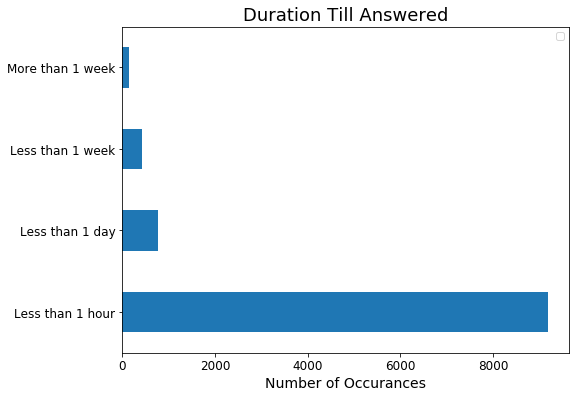

In [80]:
df_duration_counts = pd.DataFrame.from_dict(duration_counts, orient='index')
df_duration_counts.plot(kind='barh', fontsize=12, figsize=(8,6))
plt.xlabel('Number of Occurances', fontsize=14)
plt.title('Duration Till Answered', fontsize=18)
plt.legend([])
plt.show()

In [81]:
df.Code[1]

# put the code into different buckets, graph the result
# count each occurance of a '\n' as a newline
df_lines_of_code = pd.cut( [x.count('\n') for x in df.Code[ df.Code.notnull() ] ], 
                       bins=[-1, 5, 10, 20, sys.maxsize],
                       labels=False)

# labels correspond to buckets of length above
labels = np.array(['Less than 5', '6-10', '11-20', '20+'])
df_lines_of_code = labels[df_lines_of_code]

lines_of_code_count = Counter(df_lines_of_code)

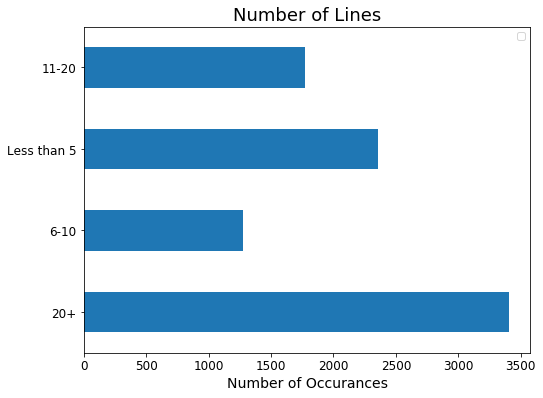

In [82]:
df_lines_of_code_count = pd.DataFrame.from_dict(lines_of_code_count, orient='index')
df_lines_of_code_count.plot(kind='barh', fontsize=12, figsize=(8,6))
plt.xlabel('Number of Occurances', fontsize=14)
plt.title('Number of Lines', fontsize=18)
plt.legend([])
plt.show()

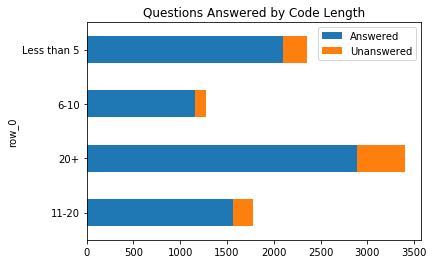

In [83]:
# stacked histogram showing percentage answered

length_vs_response = pd.crosstab([df_lines_of_code], # categories to cross tabulate
                      df.Duration[ df.Code.notnull() ].isnull()) # how to group
length_vs_response.plot(kind='barh', title="Questions Answered by Code Length", stacked=True)
plt.legend(["Answered", "Unanswered"])
plt.show()

In [86]:
# https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
from wordcloud import WordCloud

wordcloud = WordCloud(
    background_color='white',
    width=300,
    height=200,
    max_font_size=40).generate(' '.join(df_tags.Tag))
plt.figure(figsize=(8,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

TypeError: sequence item 18821: expected str instance, float found